In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time
import itertools as it
from tqdm import tqdm
from scipy.stats import norm

## Exercise 15

Linear classifier by performing stochastic gradient-descent minimization of different loss functions

In [92]:
class linear_classifier:   
        
    # Implemented loss functions
    available_loss_func = {'hinge': lambda x : max(0,1+x),
                 'exp': lambda x : np.exp(x),
                 'logistic': lambda x : np.log2(1+np.exp(x))}
       
    # Defining gradients of the loss function
    grad = {'hinge': lambda x : 0 if x < -1 else 1,
            'exp': lambda x : np.exp(x),
            'logistic': lambda x : np.exp(x) / ( (1+np.exp(x)) * np.log(2))}
    
    def __init__(self,l_f = 'hinge'):
        
        self.w = []
        
        # Assigning chosen loss function for computing stochastic gradient descent
        # either 'hinge','exp', 'logistic'
        self.l_f=l_f
        self.loss_func = linear_classifier.available_loss_func.get(l_f)
        self.grad = linear_classifier.grad.get(l_f)
        
    def train(self,X_train,Y_train, max_iter=20,ax=None,eta=0.1):
        self.SGD(X_train,Y_train,max_iter,ax,eta)
        
    def predict(self,X):
        return np.sign(X @ self.w)

    def score(self,X_test,Y_test):
        #Compute risk
        Y_hat = self.predict(X_test)
        
        return sum([Y_test[i]!=Y_hat[i] for i,_ in enumerate(Y_test)])/len(Y_test)
    
    # Stochastic gradient descent minimization algorithm
    def SGD(self,X_train,Y_train,max_iter,ax,eta):
    
        # Initializing weight vector
        w = np.zeros((1,X_train.shape[1]))

        # Learning rate
        eta = 0.1

        # Initializing iterations
        epochs = 0
        loss_func_hist = []

        while epochs < max_iter:

            t = np.random.randint(0,len(Y_train)) 
            
            # Evaluating gradient at 1 point
            grad_t = self.grad( -w[-1] @ X_train[t] * Y_train[t] ) * -(X_train[t] * Y_train[t])
            
            w_update =  w[-1]- eta * grad_t# / np.linalg.norm(grad_t)
            
            #w[-1] - eta * grad_t if self.l_f =='hinge' else w[-1] -
            
            w_update = w_update/ (np.linalg.norm(w_update))
            
            w = np.vstack((w,w_update))

            epochs += 1
            
            self.w = np.mean(w,axis=0)

            loss_func_hist.append(self.score(X_train,Y_train))
            
        if ax !=None:
            ax.plot(np.arange(0,epochs),loss_func_hist)
            ax.set_xlabel("w updates")
            ax.set_ylabel("Empirical loss")
            ax.set_title(f"Loss function: {self.l_f}") 
        #ax.show()

In [96]:
def generate_data(n,d,a):
    # Y = 1 with P = 0.5
    nY1 = np.random.binomial(n,0.5)
    
    mean = np.zeros((1,d))
    mean[0,0] = a
       
    # Crate first normal with mean and cov matrix (0,1)
    X1 = np.random.normal(loc = -mean,size= ((nY1),d))
    
    # Create second normal
    X2 = np.random.normal(loc = mean,size= ((n-nY1),d))
    
    #Putting both together and shuffle
    X = np.vstack((X1,X2))
    
    # Create Y
    Y = [1 if x < nY1 else -1 for x,aux in enumerate(X[:,0])]
    
    # Shuffle
    X,Y = shuffle(X,Y)
    
    return(X,Y)
    
def shuffle (X,Y):
    aux = np.vstack((X.T,Y)).T
    np.random.shuffle(aux)
    X,Y = np.split(aux,[-1],axis=1)
    return(X,Y.T[0])


# Estimating risk by montecarlo function
def  estimate_error (n,d,a, rep=500):

    np.random.seed(1)

    risk_hinge = []
    risk_exp = []
    risk_logistic = []
    
    risk =  pd.DataFrame(columns = ['n','a','d','hinge','exp','logistic'])
    
    for r in range(rep):
        
        # Generating data
        X,Y = generate_data(n,d,a)
        
        # Init lin classifier with different loss func
        lcl_hinge = linear_classifier(l_f='hinge')
        lcl_exp = linear_classifier(l_f='exp')
        lcl_log = linear_classifier(l_f='logistic')
        
        # Fitting the models to the data
        
        lcl_hinge.train(X,Y,20)
        lcl_exp.train(X,Y,20)
        lcl_log.train(X,Y,20)

        # Testing models 
        X_test,Y_test = generate_data(n,d,a)
        
        risk_hinge.append(lcl_hinge.score(X_test,Y_test))
        risk_exp.append(lcl_exp.score(X_test,Y_test))
        risk_logistic.append(lcl_log.score(X_test,Y_test))
    
    return (n,d,a,np.mean(risk_hinge),np.mean(risk_exp),np.mean(risk_logistic))

In [97]:
start_time = time.time()
import pandas as pd

ns= [10,100,1000]
ds= [2,10,100]
ais=np.linspace(0,5,10)

combinations = list(it.product(ns,ds,ais))

results2 = pd.DataFrame([estimate_error(comb[0],comb[1],comb[2],100) for comb in tqdm(combinations)],
                       columns=["n","d","a",'hinge','exp','logistic'])

end_time = time.time()

print("Process time: ", round(end_time-start_time),  " seconds")

100%|██████████| 90/90 [10:38<00:00, 19.80s/it]

Process time:  639  seconds


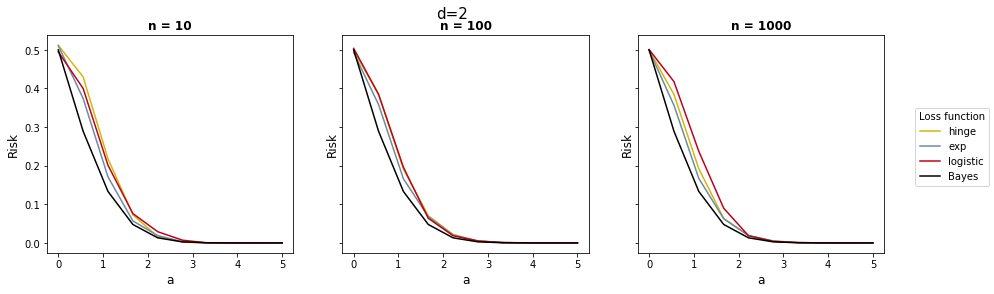

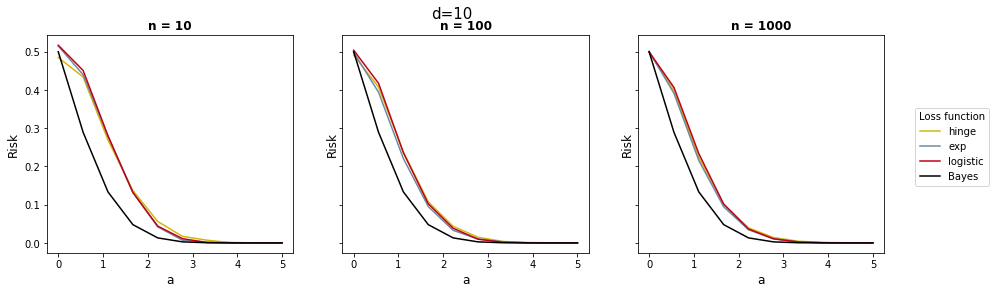

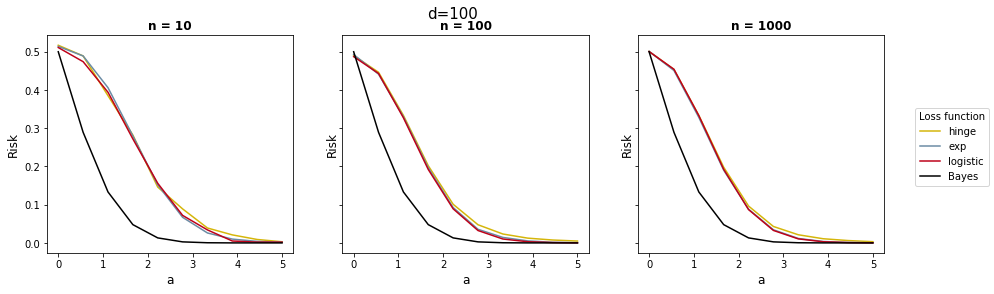

In [99]:
colors = [sns.xkcd_rgb["dark yellow"],sns.xkcd_rgb["grey blue"],sns.xkcd_rgb["scarlet"]]

for d in ds:
    fig,axes= plt.subplots(nrows = 1, ncols = 3, figsize = (15,4),sharey=True)
    for k,n in enumerate(ns):
        data = results2[['hinge','exp','logistic',"a"]][(results.n == n) & (results.d == d) ].set_index(["a"])
        axes[k].set_prop_cycle('color',colors)    
        axes[k].plot(ais,data)
        axes[k].set_title(f"n = {n}",fontsize = 12,fontweight = 1000)
        axes[k].set_xlabel("a",fontsize=12)
        axes[k].set_ylabel("Risk",fontsize=12)
        # Bayes risk plot
    
        bay_risk = [norm.cdf(x=0, loc =loc) for loc in ais]
        axes[k].plot(ais,bay_risk,color = 'black')

    
    fig.legend(['hinge','exp','logistic',"Bayes"], loc =5,title = "Loss function" )
    fig.suptitle(f"d={d}",fontsize = 15)
    fig.savefig(f"Risk_{d}",bbox_inches='tight')
    plt.show()

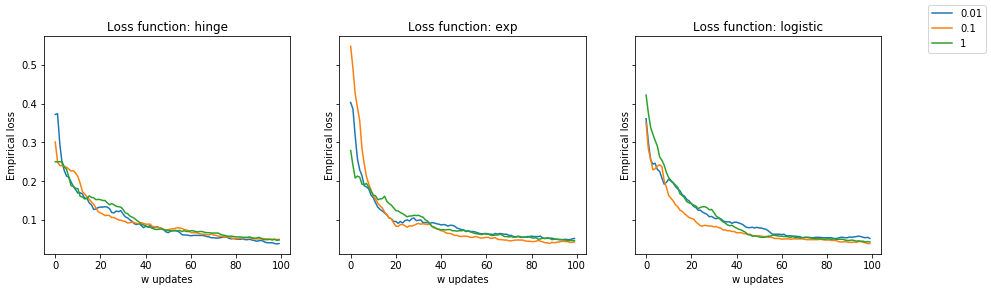

In [100]:
##########################################
# FOR TESTING in 2D
##########################################

X,Y = generate_data(1000,100,2)
fig,axes= plt.subplots(nrows = 1, ncols = 3, figsize = (15,4),sharey=True)
max_iter = 100

etas =[0.01,0.1,1]
# sns.scatterplot(X[:,0],X[:,1],hue=Y.astype(int))
# plt.show()

# Init lin classifier with different loss func
lcl_hinge = linear_classifier(l_f='hinge')
lcl_exp = linear_classifier(l_f='exp')
lcl_log = linear_classifier(l_f='logistic')

# Fitting the models to the data
for eta in etas:
    lcl_hinge.train(X,Y,max_iter=max_iter,ax = axes[0],eta= eta)
    lcl_exp.train(X,Y,max_iter=max_iter,ax = axes[1],eta =eta)
    lcl_log.train(X,Y,max_iter=max_iter,ax = axes[2],eta =eta)
    
fig.legend(etas)


# sns.scatterplot(X[:,0],X[:,1],hue= lcl_hinge.predict(X).astype(int))
# x= np.linspace(-2,2,10)
# plt.plot(x, -x*lcl_hinge.w[0]/lcl_hinge.w[1], linestyle='solid')
# plt.ylim(-3,3)
# plt.show()

# sns.scatterplot(X[:,0],X[:,1],hue= lcl_exp.predict(X).astype(int))
# x= np.linspace(-2,2,10)
# plt.plot(x, -x*lcl_exp.w[0]/lcl_exp.w[1], linestyle='solid')
# plt.ylim(-3,3)
# plt.show()

# sns.scatterplot(X[:,0],X[:,1],hue= lcl_log.predict(X).astype(int))
# x= np.linspace(-2,2,10)
# plt.plot(x, -x*lcl_log.w[0]/lcl_log.w[1], linestyle='solid')
# plt.ylim(-3,3)
# plt.show()

# Testing models 

# print("Hinge score: ",lcl_hinge.score(X,Y),
#       "\nweights: ",lcl_hinge.w)
# print("Exp score: ",lcl_exp.score(X,Y),
#      "\nweights: ",lcl_exp.w)
# print("Log score: ",lcl_log.score(X,Y),
#       "\nweights: ",lcl_log.w)

fig.savefig(f"Learning_rate",bbox_inches='tight')